In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **`Pizza Steak Classifier`**

## Part 03A

## Introduction to CNN and Computer Vision with Tensorflow

**Note**: 

* You can use CNNs for image data as well as text data. CNNs exploit local relationships very well.
* An image has patterns which are very well spatially correlated on a local scale (i.e. we don't have per pixel patterns, rather they span in a spatial location with a definite structure)
* So if a sentence has a structure which is influenced more by local nearby relationships (in context of the NLP problem), CNNs will work really well.

**Examples**
* Simple image classification, whether a picture of a food contains pizza or a steak
* Detect whether or not an object appears in an image (i.e. did a specific car pass through the security cameras)

**Steps**
* Getting the dataset. 
    * Where to keep/host large datasets in case > gdrive storage. 
    * Dataset fetching scripts
    * Common dataset sources for different kinds of problems
    * Version controlling or putting dataset in a remote repo : `dvc`
* Preparing the dataset
    * Making sure it's the right size.
    * Dataset directory structure/Creating a CustomDataset Class
    * Augmentation techniques
    * Noise removal
    * Batch Data Loader, prefetching (Important for large datasets)
* Creating a baseline model 
* Experimenting with large models (on small training subset)
* Fitting and monitoring the training (TensorBoard, Weights & Biases)
* Visualizing the predictions
* Evaluating the model
* Improving the model
* Comparing the models
* Making a prediction with the trained model

## `ClassicImageDatasetDirectory`

* Two folders with train and test images
* Each of train and test contain subfolders with class_names
* Each class_names folder contains images 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.image import ClassicImageDataDirectory

In [ ]:
data_dir = '../data/pizza_steak/'
subsets = ['train', 'test']
class_names = ['pizza', 'steak']

In [ ]:
imgdir = ClassicImageDataDirectory(data_dir, target_image_size=(224, 224), dtype=np.uint8)

### Class Names

In [ ]:
imgdir.class_names, imgdir.class_labels

(('steak', 'pizza'), (0, 1))

### Counts

In [ ]:
imgdir.labelcountdf

,label,name,count_train,count_test
0,0,steak,750,250
1,1,pizza,750,250


We have 750 images each in the train set and 250 images each in the test set for both the classes.

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='name'>

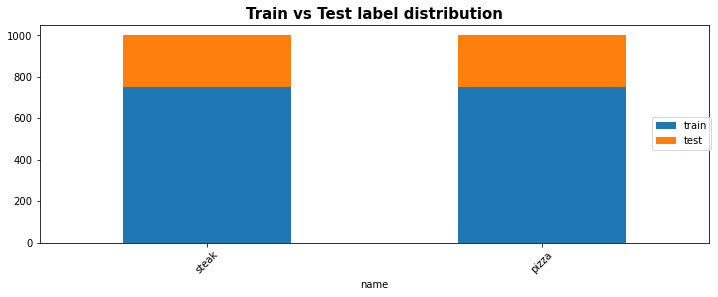

In [ ]:
imgdir.plot_labelcounts()

## Load a Batch 

In [ ]:
datagen = imgdir.load(32)
batch = next(datagen)

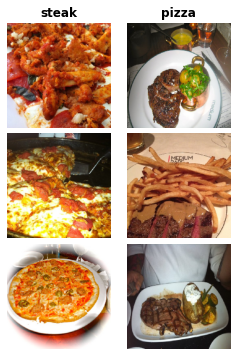

In [ ]:
batch.view_random_images(class_names='all', n_each=3);

## A (typical) architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.

Components of a convolutional neural network:


| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |


How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

# An end-to-end example

Classes: `pizza`, `steak`

* 750 training examples for each class
* 250 test examples for each class

[Original author's paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) used RandomForest for establishing the baseline accuracy of 50.76%

> **Note**: A baseline is a score or en evaluation metric which is based on the performance of a relatively simple model on the dataset. Any model we build should atleast outperform the baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, callbacks

## Basic structure of a convolution neural network 

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run as a 2D kernel with depth and output is 2D.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.


What is a **feature**?

* Neural networks are automatic feature extractors. They "learn" features, and the weights + the mechanism of matrix multiplication and non-linearity (and other specifics) is called feature extractor. 
* We can handcraft features for an image. For example, for a pizza, the presence of a circular shape is important. But given an arbitrary image, how do we identify the presence of a circular feature? Neural networks learn this and hopefully some of the neurons get highly activated when they see a circular shape in the image.
* So basically combining features: f1: circular shape, f2: red patches of circular inside a circle (pepporini), etc etc many non-tangible features lead the network to predict in favour of a pizza.

### `Conv2D` over images


* Whether the image has depth or not, the output will still have depth = 1 (for one kernel output)
* Number of filters decide the output depth
* When the image has depth, the applied kernel is (3, 3, depth)
    * and hence has that many more parameters    
* The bias is shared accross the depth in case a depth kernel is applied
* A padding of *same* in convolution means enough padding to make the input size same as the output size after convolution

### Convolution over depth channels

In [ ]:
model_1channel = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(filters=1, kernel_size=3)
])

model_1channel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1channel.input_shape, model_1channel.output_shape

((None, 224, 224, 1), (None, 222, 222, 1))

In [ ]:
model_3channel = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=1, kernel_size=3)
])

model_3channel.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 1)       28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3channel.input_shape, model_3channel.output_shape

((None, 224, 224, 3), (None, 222, 222, 1))

### `same` padding

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=1, kernel_size=3, padding='same')
])
model.input_shape, model.output_shape

((None, 224, 224, 3), (None, 224, 224, 1))

### Multiple filters

* Each filter learns a specific feature from the same kind of input. (This is very similar to attention heads in a transformer)

In [ ]:
model_3channel_multifilters = tf.keras.models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=10, kernel_size=3)
])

model_3channel_multifilters.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 10)      280       
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3channel_multifilters.input_shape, model_3channel_multifilters.output_shape

((None, 224, 224, 3), (None, 222, 222, 10))

## Pooling

**Note**:

* A padding value of *same* will pad enough zeros on boundaries of the input to make pooling operation move with an equal stride as the kernel size.
    * This results in an output size = $(I+ 2p)/K$
    * E.g. input = 3, kernel_size = 2, padding = 0.5 (1 on any of the side; left or right). output = 2
    * [Padding in Pooling](https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling#:~:text=The%20whole%20purpose%20of%20pooling,is%20often%20for%20convolutional%20layers.)
* A common pattern in CNN is to have *same* padding for convolution to retain the same size of the input and then half the size (reduce the dimensionality) of the output by using Pooling (`MaxPool`, `AvgPool` -> Find the most relevant features, denoising) by using a stride of 2, kernel_size 2.
    * Reduces the dimensionality
    * Finds most important patterns
    * Denoising
    * As a side note: stride, kernel_size, dilated convolutions
* Pooling is a fixed operation, while convolutions can be learned. 

[Stackoverflow: Valid vs Same](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t)


* `"VALID"` = without padding:

    ```
    inputs:         1  2  3  4  5  6  7  8  9  10 11 (12 13)
                      |________________|                dropped
                                     |_________________|
    ```

* `"SAME"` = with zero padding:

    ```
                   pad|                                      |pad
       inputs:      0 |1  2  3  4  5  6  7  8  9  10 11 12 13|0  0
                   |________________|
                                  |_________________|
                                                 |________________|
    ```

In [ ]:
model_pool_validpad = tf.keras.Sequential([
    layers.Input(shape=(9, 9, 3)),
    layers.MaxPool2D(pool_size=4, padding='valid')
])

model_pool_validpad.input_shape, model_pool_validpad.output_shape

((None, 9, 9, 3), (None, 2, 2, 3))

The 9th input is dropped here with padding = `valid`.

In [ ]:
model_pool_samepad = tf.keras.Sequential([
    layers.Input(shape=(9, 9, 3)),
    layers.MaxPool2D(pool_size=4, padding='same')
])

model_pool_samepad.input_shape, model_pool_samepad.output_shape

((None, 9, 9, 3), (None, 3, 3, 3))

The input is padding with 3 extra zeros (2 on one side, 1 on other), so that the pooling operation can move with stride = kernel_size 

## CNN pattern of `same` padding convolution layer, followed by halving the size with pooling

In [ ]:
from src.visualize import plot_keras_model

In [ ]:
model = tf.keras.models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, padding='same'),
    layers.Conv2D(5, 3, activation='relu', padding='same'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(1, 3, activation='relu', padding='same'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='Adam')

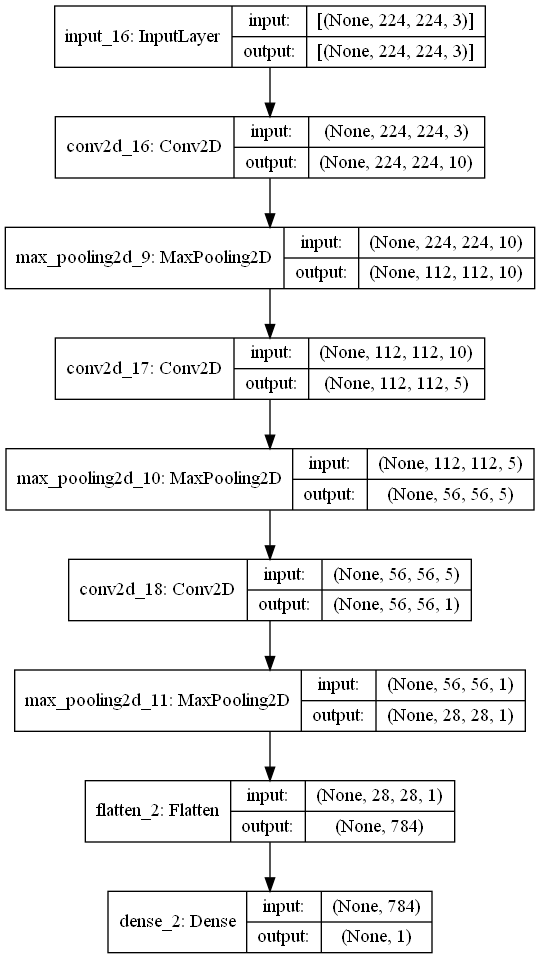

In [ ]:
plot_keras_model(model, show_shapes=True)

In [ ]:
tfmodels = {}

## Reimplementing a VGG like architecture ([TinyVGG](https://poloclub.github.io/cnn-explainer/))

## Model 1: TinyVGG

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)

# Set the seed
tf.random.set_seed(SEED)

### Preprocess the data

- [Train and validation split in ImageDataGenerator](https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.0)

### Setup the train and test data directories


In [ ]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Import the data from directories and turn it into batches

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=IMAGE_DIM,
                                               class_mode='binary',
                                               subset='training',
                                               seed=SEED)


validation_data = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=IMAGE_DIM,
                                                    class_mode='binary',
                                                    subset='validation',
                                                    seed=SEED)

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=32,
                                             target_size=IMAGE_DIM,
                                             class_mode='binary',
                                             shuffle=False)


Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Create the model

In [ ]:
from src.evaluate import KerasMetrics
from src.visualize import plot_learning_curve
from sklearn import metrics


In [ ]:
# Create the CNN model
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(pool_size=2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='TinyVGG')

# Compile
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "TinyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28090)             0   

### Fit the model!

In [ ]:
history = model.fit(train_data, epochs=10, steps_per_epoch=len(train_data),
                    validation_data=validation_data, validation_steps=len(validation_data))

tfmodels[model.name] = model

Epoch 1/10
38/38 [==============================] - 15s 374ms/step - loss: 0.6487 - f1: 0.5100 - accuracy: 0.6207 - val_loss: 0.6390 - val_f1: 0.7291 - val_accuracy: 0.6633
Epoch 2/10
38/38 [==============================] - 12s 322ms/step - loss: 0.5056 - f1: 0.7573 - accuracy: 0.7563 - val_loss: 0.4790 - val_f1: 0.7450 - val_accuracy: 0.7800
Epoch 3/10
38/38 [==============================] - 12s 320ms/step - loss: 0.4102 - f1: 0.8167 - accuracy: 0.8170 - val_loss: 0.4830 - val_f1: 0.7966 - val_accuracy: 0.8033
Epoch 4/10
38/38 [==============================] - 10s 270ms/step - loss: 0.3482 - f1: 0.8383 - accuracy: 0.8455 - val_loss: 0.4577 - val_f1: 0.7787 - val_accuracy: 0.7900
Epoch 5/10
38/38 [==============================] - 6s 164ms/step - loss: 0.3133 - f1: 0.8795 - accuracy: 0.8762 - val_loss: 0.6343 - val_f1: 0.6550 - val_accuracy: 0.7233
Epoch 6/10
38/38 [==============================] - 7s 190ms/step - loss: 0.2893 - f1: 0.8914 - accuracy: 0.8952 - val_loss: 0.4823 - va

### Learning Curve

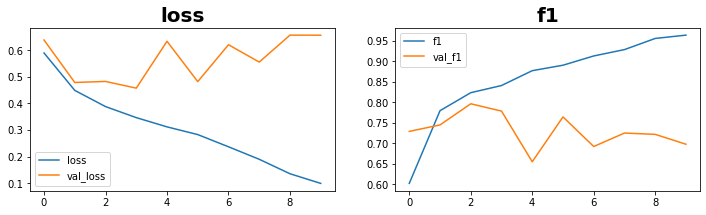

In [ ]:
plot_learning_curve(model.history.history, extra_metric='f1');

### Prediction evaluation

In [ ]:
y_test_preds_prob = model.predict(test_data)
y_test_preds = y_test_preds_prob.round().flatten()

In [ ]:
metrics.accuracy_score(y_test_preds, test_data.labels)

0.818

In [ ]:
print(metrics.classification_report(y_test_preds, test_data.labels))

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82       243
         1.0       0.83      0.81      0.82       257

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



The model is highly overfitted, and also seems the like the architecture of the model is too complex for this task. We should ideally try a more simpler, better regularized model, but let us try if data augmentation helps.

## Model 2: TinyVGG with Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)

### Preprocess the data (Augmentation)

In [ ]:
# Train: Augmented 
train_datagen_aug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=0.2, # rotate the image slightly
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True, # flip the image on the horizontal axis
    validation_split=0.2)


# Train: Create another with no augmentation just scaling
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

# Test datagen (No augmentation)
test_datagen = ImageDataGenerator(rescale=1/255.0)


### Setup the train and test directories

In [ ]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Import the data from directories and turn it into batches

In [ ]:
train_data_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='training',
    seed=SEED)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='validation',
    seed=SEED)

train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    subset='training',
    seed=SEED)


test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=IMAGE_DIM,
    class_mode='binary',
    shuffle=False)


Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Compare Normal and Augmented image

In [ ]:
images, label = train_data.next()
images_aug, label_aug = train_data_aug.next() # label_aug is same as label

In [ ]:
from matplotlib.gridspec import GridSpec

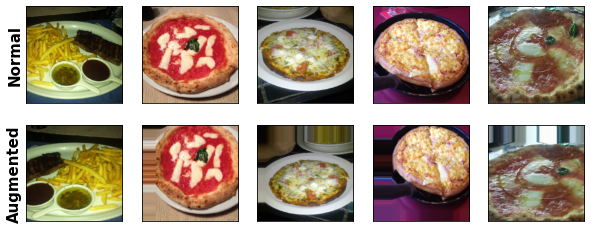

In [ ]:
n_each = 5
fig = plt.figure(figsize=(n_each*2, 2*2))
gs = GridSpec(2, n_each)

k = 0
for i in range(5):
    for j, img in zip(range(2), [images[k], images_aug[k]]):
        ax = plt.subplot(gs[j, i])
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow(img)        
        k += 1
        
plt.subplot(gs[0, 0]).set_ylabel('Normal', fontdict=dict(weight='bold', size=15))
plt.subplot(gs[1, 0]).set_ylabel('Augmented', fontdict=dict(weight='bold', size=15));

### Create the model

* Just for practice, I will write it again. Although you can just clone the model as follows:

```python
# clone
tf.keras.models.clone_model(model)

# recompile
model.compile(...)
```

In [ ]:
# Set seed
tf.random.set_seed(SEED)

# Create the model
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='TinyVGG-data-augment')

# Compile the model
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(), metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "TinyVGG-data-augment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28090)    

### Fit the model

In [ ]:
history = model.fit(train_data_aug, epochs=10, steps_per_epoch=len(train_data_aug),
                    validation_data=validation_data, validation_steps=len(validation_data))

tfmodels[model.name] = model

Epoch 1/10
38/38 [==============================] - 16s 408ms/step - loss: 0.6782 - f1: 0.5640 - accuracy: 0.5592 - val_loss: 0.4766 - val_f1: 0.8043 - val_accuracy: 0.8067
Epoch 2/10
38/38 [==============================] - 19s 509ms/step - loss: 0.5062 - f1: 0.7659 - accuracy: 0.7582 - val_loss: 0.5521 - val_f1: 0.6335 - val_accuracy: 0.7333
Epoch 3/10
38/38 [==============================] - 25s 662ms/step - loss: 0.5090 - f1: 0.7437 - accuracy: 0.7658 - val_loss: 0.5044 - val_f1: 0.7649 - val_accuracy: 0.7733
Epoch 4/10
38/38 [==============================] - 31s 829ms/step - loss: 0.4991 - f1: 0.7742 - accuracy: 0.7794 - val_loss: 0.4525 - val_f1: 0.7869 - val_accuracy: 0.7933
Epoch 5/10
38/38 [==============================] - 30s 800ms/step - loss: 0.4667 - f1: 0.8004 - accuracy: 0.7941 - val_loss: 0.4465 - val_f1: 0.7949 - val_accuracy: 0.8033
Epoch 6/10
38/38 [==============================] - 24s 633ms/step - loss: 0.4439 - f1: 0.8006 - accuracy: 0.7937 - val_loss: 0.4823 - 

### Learning Curve

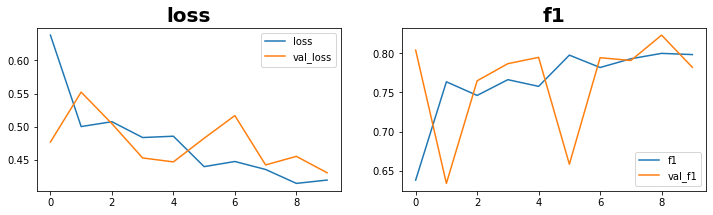

In [ ]:
plot_learning_curve(history.history, extra_metric='f1');

### Prediction Evaluatiom

In [ ]:
y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.round().flatten()

metrics.accuracy_score(test_data.labels, y_test_pred)

0.89

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       250
           1       0.93      0.85      0.89       250

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



Data Augmentation seems to have solved the problem of severe overfitting. But the learning curve seems to fluctuate a lot. So now, let us try to find a good value with `LearningRateScheduler`

## Find a better Learning Rate

### `LearningRateScheduler`

In [ ]:
num_epochs = 30
lr_vals = np.logspace(-4, -2, num_epochs)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: lr_vals[epoch])

### Clone and Recompile

In [ ]:
model = tf.keras.models.clone_model(model)
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(), 
              metrics=[KerasMetrics.f1, 'accuracy'])

### Fit the model

In [ ]:
data_percent = 30
train_steps = int(len(train_data)*data_percent/100)

In [ ]:
model.fit(train_data, steps_per_epoch=train_steps, validation_data=validation_data, validation_steps=len(validation_data),
         callbacks=[lr_scheduler], epochs=num_epochs)

Epoch 1/30
11/11 [==============================] - 5s 424ms/step - loss: 0.7039 - f1: 0.3577 - accuracy: 0.4836 - val_loss: 0.6856 - val_f1: 0.1930 - val_accuracy: 0.5500
Epoch 2/30
11/11 [==============================] - 4s 391ms/step - loss: 0.6763 - f1: 0.2440 - accuracy: 0.5845 - val_loss: 0.6631 - val_f1: 0.5791 - val_accuracy: 0.6800
Epoch 3/30
11/11 [==============================] - 4s 375ms/step - loss: 0.6481 - f1: 0.5477 - accuracy: 0.7035 - val_loss: 0.6352 - val_f1: 0.6642 - val_accuracy: 0.7100
Epoch 4/30
11/11 [==============================] - 4s 354ms/step - loss: 0.6154 - f1: 0.7024 - accuracy: 0.7443 - val_loss: 0.6008 - val_f1: 0.7137 - val_accuracy: 0.7333
Epoch 5/30
11/11 [==============================] - 4s 345ms/step - loss: 0.5674 - f1: 0.7468 - accuracy: 0.7749 - val_loss: 0.5905 - val_f1: 0.6023 - val_accuracy: 0.7000
Epoch 6/30
11/11 [==============================] - 4s 337ms/step - loss: 0.5363 - f1: 0.6573 - accuracy: 0.7250 - val_loss: 0.5772 - val_f1

### Learning curve vs Loss

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.head()

,loss,f1,accuracy,val_loss,val_f1,val_accuracy,lr
0,0.700492,0.191884,0.502841,0.685644,0.192999,0.550000,0.000100
1,0.673764,0.420602,0.627841,0.663074,0.579146,0.680000,0.000117
2,0.643091,0.521881,0.676136,0.635154,0.664246,0.710000,0.000137
3,0.607667,0.725193,0.741477,0.600765,0.713734,0.733333,0.000161
4,0.560047,0.763947,0.784091,0.590508,0.602253,0.700000,0.000189


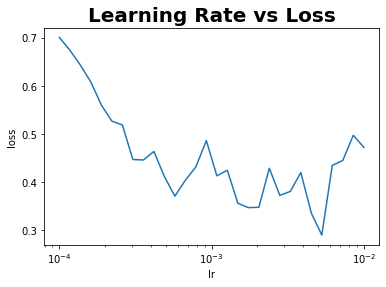

In [ ]:
plt.semilogx(history_df['lr'], history_df['loss']);
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Learning Rate vs Loss', fontdict=dict(weight='bold', size=20));

Seems like we should keep learning rate as low as possible at $10^{-4}$

In [ ]:
best_lr = 10**(-4) + 1*(10**(-4))
best_lr

0.0002

## Tiny VGG - With data Augmentation - better learning_rate

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)
LR_VAL = best_lr

### Setup the train and test directory

In [ ]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Preprocess the data (Augmentation)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.0)

### Import the data from directories and turn them into batches

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_DIM, class_mode='binary', subset='training', seed=SEED)
validation_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_DIM, class_mode='binary', subset='validation', seed=SEED)
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_DIM, class_mode='binary', shuffle=False)

Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
test_datagen.flow()

### Create the model

In [ ]:
# Create the model
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='TinyVGG-data-augment-bestlr')

# Compile the model
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=LR_VAL), metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "TinyVGG-data-augment-bestlr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 280

### Fit the model

In [ ]:
history = model.fit(train_data, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data), epochs=20)
tfmodels[model.name] = model

Epoch 1/20
38/38 [==============================] - 32s 829ms/step - loss: 0.6873 - f1: 0.0790 - accuracy: 0.5109 - val_loss: 0.6530 - val_f1: 0.4572 - val_accuracy: 0.6233
Epoch 2/20
38/38 [==============================] - 26s 672ms/step - loss: 0.6603 - f1: 0.5742 - accuracy: 0.6191 - val_loss: 0.5877 - val_f1: 0.6861 - val_accuracy: 0.7167
Epoch 3/20
38/38 [==============================] - 26s 698ms/step - loss: 0.5915 - f1: 0.7157 - accuracy: 0.7006 - val_loss: 0.5764 - val_f1: 0.6203 - val_accuracy: 0.7033
Epoch 4/20
38/38 [==============================] - 33s 880ms/step - loss: 0.5478 - f1: 0.7165 - accuracy: 0.7318 - val_loss: 0.5333 - val_f1: 0.7459 - val_accuracy: 0.7500
Epoch 5/20
38/38 [==============================] - 24s 630ms/step - loss: 0.5286 - f1: 0.7155 - accuracy: 0.7371 - val_loss: 0.5058 - val_f1: 0.7421 - val_accuracy: 0.7533
Epoch 6/20
38/38 [==============================] - 23s 614ms/step - loss: 0.5061 - f1: 0.7703 - accuracy: 0.7672 - val_loss: 0.4736 - 

### Learning Curve

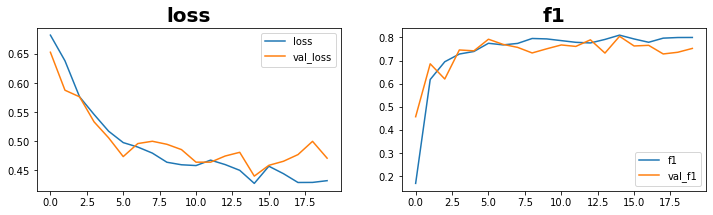

In [ ]:
plot_learning_curve(model, extra_metric='f1');

### Prediction Evaluation

In [ ]:
y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.round().flatten()
metrics.accuracy_score(test_data.labels, y_test_pred)

0.87

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_pred.flatten()))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       250
           1       0.89      0.84      0.87       250

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



We managed to improve our performance even further!

## Model4 : TinyVGG - data augmentation - Dropout in last layer

### Create the model

In [ ]:
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPool2D(2, padding='same'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
], name='TinyVGG-data-augment-dropout-last')

# Compile the model
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=LR_VAL), metrics=[KerasMetrics.f1, 'accuracy'])

# Summarise the model
model.summary()

Model: "TinyVGG-data-augment-dropout-last"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_6 (Flatten)          (Non

### Fit the model!

In [ ]:
history = model.fit(train_data, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data), epochs=20)
tfmodels[model.name] = model

Epoch 1/20
38/38 [==============================] - 50s 1s/step - loss: 0.6778 - f1: 0.3559 - accuracy: 0.5642 - val_loss: 0.6493 - val_f1: 0.3497 - val_accuracy: 0.6000
Epoch 2/20
38/38 [==============================] - 26s 680ms/step - loss: 0.6069 - f1: 0.6652 - accuracy: 0.6933 - val_loss: 0.5576 - val_f1: 0.7268 - val_accuracy: 0.7400
Epoch 3/20
38/38 [==============================] - 24s 623ms/step - loss: 0.5485 - f1: 0.7068 - accuracy: 0.7142 - val_loss: 0.5525 - val_f1: 0.7334 - val_accuracy: 0.7000
Epoch 4/20
38/38 [==============================] - 22s 583ms/step - loss: 0.5295 - f1: 0.7186 - accuracy: 0.7325 - val_loss: 0.5277 - val_f1: 0.7266 - val_accuracy: 0.7467
Epoch 5/20
38/38 [==============================] - 23s 602ms/step - loss: 0.5107 - f1: 0.7489 - accuracy: 0.7508 - val_loss: 0.4972 - val_f1: 0.7393 - val_accuracy: 0.7667
Epoch 6/20
38/38 [==============================] - 25s 659ms/step - loss: 0.5027 - f1: 0.7401 - accuracy: 0.7517 - val_loss: 0.4851 - val

Training with Dropout significantly took more time!

### Learning Curve

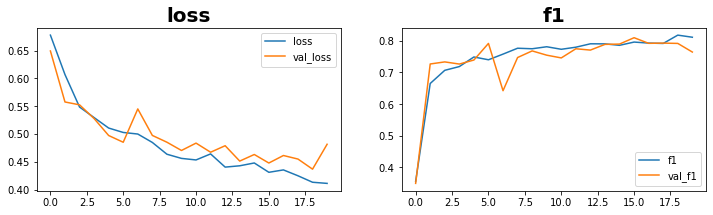

In [ ]:
plot_learning_curve(model, extra_metric='f1');

### Prediction Evaluation

In [ ]:
y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.round()
metrics.accuracy_score(test_data.labels, y_test_pred)

0.876

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_pred, target_names=imgdir.class_names))

              precision    recall  f1-score   support

       steak       0.85      0.92      0.88       250
       pizza       0.91      0.84      0.87       250

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



Looks like this isn't so much of a downgrade and helped reduced a bit of overfitting. If we train for longer, the learning curve indicates that loss will continue to decrease.

## Model5: Dense

### Create the model

In [ ]:
model = tf.keras.models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='Simple-Dense')

# Compile the model
model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(), metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
model.summary()

Model: "Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 1204232   
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,204,313
Trainable params: 1,204,313
Non-trainable params: 0
_________________________________________________________________


These are way too many parameters!

### Fit the model

In [ ]:
history = model.fit(train_data, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data), epochs=20)
tfmodels[model.name] = model

Epoch 1/20
38/38 [==============================] - 38s 1s/step - loss: 1.1983 - f1: 0.4586 - accuracy: 0.5219 - val_loss: 0.7138 - val_f1: 0.6342 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 36s 952ms/step - loss: 0.6971 - f1: 0.6143 - accuracy: 0.5173 - val_loss: 0.6557 - val_f1: 0.6400 - val_accuracy: 0.6733
Epoch 3/20
38/38 [==============================] - 36s 960ms/step - loss: 0.6487 - f1: 0.5842 - accuracy: 0.6568 - val_loss: 0.6336 - val_f1: 0.5534 - val_accuracy: 0.6700
Epoch 4/20
38/38 [==============================] - 35s 924ms/step - loss: 0.6144 - f1: 0.5791 - accuracy: 0.6838 - val_loss: 0.6629 - val_f1: 0.3167 - val_accuracy: 0.5867
Epoch 5/20
38/38 [==============================] - 36s 955ms/step - loss: 0.6628 - f1: 0.4036 - accuracy: 0.6148 - val_loss: 0.6955 - val_f1: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 35s 924ms/step - loss: 0.6862 - f1: 0.0000e+00 - accuracy: 0.4998 - val_loss: 0.68

### Learning Curve

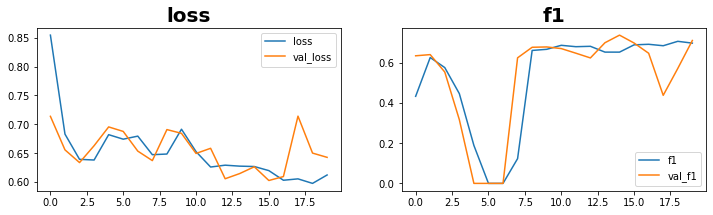

In [ ]:
plot_learning_curve(model, extra_metric='f1');

### Prediction Evaluation

In [ ]:
y_test_pred_prob = model.predict(test_data)
y_test_pred = y_test_pred_prob.round()
metrics.accuracy_score(test_data.labels, y_test_pred)

0.708

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61       250
           1       0.64      0.95      0.77       250

    accuracy                           0.71       500
   macro avg       0.77      0.71      0.69       500
weighted avg       0.77      0.71      0.69       500



Even with so many more parameters, we could not perform as close to the TinyVGG CNN Model!

### Compare Models

In [ ]:
compdf = []
for name, model in tfmodels.items():
    y_pred_prob_test = model.predict(test_data)
    y_pred_test = y_pred_prob_test.round()
    crdf = pd.DataFrame(metrics.classification_report(test_data.labels, y_pred_test, target_names=test_data.class_indices, output_dict=True))
    crdf['model'] = name
    compdf.append(crdf)
    
    
compdf = pd.concat(compdf)
compdf.index.name = 'metric'
compdf.reset_index(inplace=True)

In [ ]:
compdf_small = compdf.loc[compdf['metric'] != 'support', ['metric', 'weighted avg', 'model']].rename(columns={'weighted avg': 'value'})
acc_df = compdf.loc[compdf['metric'] != 'support', ['model', 'accuracy']].drop_duplicates().melt(id_vars='model', var_name='metric')

In [ ]:
compdf_small = pd.concat([compdf_small, acc_df]).sort_values('model')

In [ ]:
import seaborn as sns

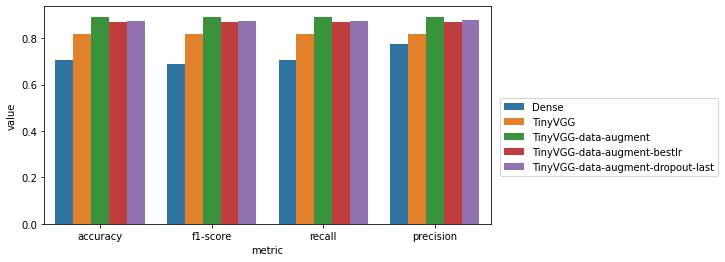

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='metric', y='value', hue='model', data=compdf_small)
plt.legend(bbox_to_anchor=[1.01, 0.6])

### Predict on random image

In [ ]:
def view_random_prediction(model, data_dir, subset, datagen, target_image_size=None, binary_prob_thresh=0.5):
    imgdir = ClassicImageDataDirectory(data_dir, target_image_size=target_image_size)
    imgen = imgdir.load(1, subset=subset)
    batch = next(imgen)
    
    img, cls_lab = datagen.flow(batch.train_images, batch.train_labels).next()
    
    cls_lab = int(cls_lab)
    pred_probs = np.squeeze(model.predict(img))
    pred_ndims = len(pred_probs.shape)
    
    if pred_ndims > 1:
        pred_lab = pred_probs.argmax(axis=1)
    else:
        pred_lab = (pred_probs > binary_prob_thresh).astype(np.uint8)
            
    cls_name, pred_name = imgdir.class_names[cls_lab], imgdir.class_names[pred_lab]
    
    fig, ax = plt.subplots()
    ax.imshow(np.squeeze(img))
    ax.set_xlabel(cls_name, fontdict=dict(weight='bold', size=20))
    ax.set_xticks([])
    ax.set_yticks([])

    if cls_lab == pred_lab:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(pred_name + f'({pred_prob:.2f})', fontdict=dict(weight='bold', size=20), color=color)
    return ax    

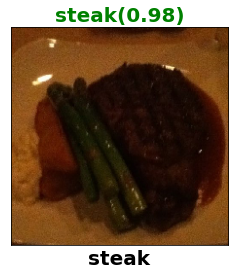

In [ ]:
view_random_prediction(tfmodels['TinyVGG-data-augment'], '../data/pizza_steak/', 'test', test_datagen, (224, 224));

Ideas of how to evaluate and visualize:

* View by confidence of the model [low, medium, high] or maybe a thresh
* View by class_name: predicted, true
* View by type of prediction [fp,tp,fn,tn]

In [ ]:
from src.image import ImageDataset, ClassicImageDataDirectory

In [ ]:
class ImageClassificationEvaluator:
    
    def __init__(self, model, data, binary_prob_thresh=0.5):
        self.model = model
        self.data = data
        self.binary_prob_thresh = binary_prob_thresh
        self.pred_probs = np.squeeze(self.model.predict(self.data))
        pred_ndims =len(self.pred_probs.shape)
        
        if pred_ndims > 1:
            self.preds = self.pred_probs.argmax(axis=1)
        else:
            self.preds = (self.pred_probs > binary_prob_thresh).astype(np.uint8)
            
        self.clf_report = metrics.classification_report(self.preds, self.data.labels, target_names=self.data.class_indices, output_dict=True)
        self.clf_report_str = metrics.classification_report(self.preds, self.data.labels, target_names=self.data.class_indices, output_dict=False)
        
#         self.imgdir = ClassicImageDataDirectory(self.data.directory, target_image_size=None)

        
        
    def print_clf_report(self):
        print(self.clf_report_str)
           